In [1]:
import os

# Check if the current directory ends with 'data'
if os.getcwd()[-4:] != 'data':
    # Create the 'data' directory if it doesn't exist
    if not os.path.exists('data'):
        os.mkdir('data')

In [2]:
import os
print(os.getcwd())

d:\python notebooks


In [3]:
from helper_lib import *

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
# Load and preprocess MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(576, 64)
        self.fc2 = nn.Linear(64, 10)

        self.input_shape = (1, 1, 28, 28)


    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

file_path_cnn = 'data/cnn_model.pth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = CNNModel().to(DEVICE)
save_layer_shapes(cnn_model)

if os.path.exists(file_path_cnn):
    cnn_model.load_state_dict(torch.load(file_path_cnn))
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters())

    num_epochs = 20
    cnn_model.to(DEVICE)

    for epoch in range(num_epochs):
        cnn_model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)

            # Forward pass
            outputs = cnn_model(data)
            loss = criterion(outputs, target)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
                    f'Loss: {running_loss/100:.4f}')
                running_loss = 0.0

        # Validation
        cnn_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                outputs = cnn_model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Validation Accuracy: {100 * correct / total:.2f}%')
        
    torch.save(cnn_model.state_dict(), file_path_cnn)


C:\Users\Comp\AppData\Local\Temp\ipykernel_14736\601904121.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(file_path_cnn))


In [6]:
# Function to get activations of the last layer
def activations_from_whole_dataset(model, loader, output_device, compute_labels=False):
    model.eval()
    activations = []
    labels = []
    with torch.no_grad():
        for data, targets in loader:
            output = model(data.to(DEVICE))
            activations.append(output.to(output_device))
            if compute_labels:
                labels.append(targets)
    if compute_labels:
        return torch.cat(activations), torch.cat(labels)
    else:
        return torch.cat(activations)

In [7]:
reference_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=False)
reference_train_activations, reference_labels = activations_from_whole_dataset(cnn_model, reference_train_loader, output_device=DEVICE, compute_labels=True)


In [8]:
mnist_by_digit_lists = [[] for _ in range(10)]

# Iterate over the dataset and append images to the corresponding list
for image, label in mnist_train:
    mnist_by_digit_lists[label].append(image)

In [9]:
# Get activations from the CNN model
train_activations = activations_from_whole_dataset(cnn_model, train_loader, output_device='cpu')
test_activations = activations_from_whole_dataset(cnn_model, test_loader, output_device='cpu')

# Create datasets and dataloaders for the activations
train_dataset_SAE = TensorDataset(torch.FloatTensor(train_activations))
test_dataset_SAE = TensorDataset(torch.FloatTensor(test_activations))
train_loader_SAE = DataLoader(train_dataset_SAE, batch_size=128, shuffle=True)
test_loader_SAE = DataLoader(test_dataset_SAE, batch_size=128, shuffle=False)

In [10]:
# Define the Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

        self.input_shape = (1, input_size)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return encoded, decoded

# Hyperparameters
input_size = 10  # Size of the last layer of CNN (10 for MNIST)
hidden_size = 20
learning_rate = 1e-3
num_epochs = 50
sparsity_weight = 1e-5

file_path_sae = 'data/sparse_autoencoder_mnist.pth'

if os.path.exists(file_path_sae):
    sae = SparseAutoencoder(input_size, hidden_size).to(DEVICE)
    sae.load_state_dict(torch.load(file_path_sae))
else: 
    sae = SparseAutoencoder(input_size, hidden_size).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(sae.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        sae.train()
        total_loss, total_reconstruction_loss, total_weighted_sparcity_loss = 0, 0, 0

        for data in train_loader_SAE:
            inputs = data[0].to(DEVICE)

            # Forward pass
            encoded, decoded = sae(inputs)

            # Compute loss
            reconstruction_loss = criterion(decoded, inputs)
            sparsity_loss = torch.sum(torch.abs(encoded))
            loss = reconstruction_loss + sparsity_weight * sparsity_loss

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_reconstruction_loss += reconstruction_loss.item()
            total_weighted_sparcity_loss += (sparsity_weight * sparsity_loss).item()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader_SAE):.4f}')
        print(f'Reconstruction loss: {reconstruction_loss/len(train_loader_SAE):.4f}')
        print(f'Weighted sparcity loss: {total_weighted_sparcity_loss/len(train_loader_SAE):.4f}')
        

    # Save the model
    torch.save(sae.state_dict(), file_path_sae)

sae.eval()

save_layer_shapes(sae, get_output_shape=lambda x: x[-1])

C:\Users\Comp\AppData\Local\Temp\ipykernel_14736\3123111968.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load(file_path_sae))


{'encoder': (torch.Size([1, 10]), torch.Size([1, 20])),
 'decoder': (torch.Size([1, 20]), torch.Size([1, 10]))}

tensor([-27.9033, -11.6071,   2.7997, -11.8030,  41.2298, -15.4777, -10.1379,
         -0.5054, -11.4029, -11.6894])
prediction = 4
prediction according to reconstructed activations = 4
actual label = 4


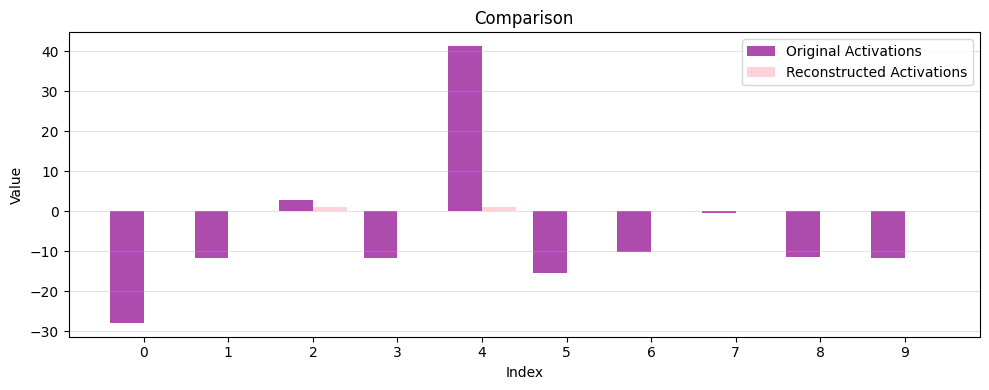

In [11]:
import matplotlib.pyplot as plt # type: ignore

# what example to visualize
number = np.random.randint(len(reference_train_activations))

with torch.no_grad():
    reconstructed_cnn_activations = sae(reference_train_activations[number])[-1].detach()
    cnn_activations = reference_train_activations[number].cpu()
    print(cnn_activations)
    reconstructed_cnn_activations = reconstructed_cnn_activations.cpu()

print(f"prediction = {torch.argmax(cnn_activations).item()}")
print(f"prediction according to reconstructed activations = {torch.argmax(reconstructed_cnn_activations).item()}")
print(f"actual label = {reference_labels[number]}")
# Ensure that both activations are on a similar scale if necessary
# If the values differ significantly, you might want to normalize them.

# Bar Chart
plt.figure(figsize=(10, 4))


# Set up the positions and bar width
bar_width = 0.4
indices = np.arange(10)

# Plot the original cnn activations
plt.bar(indices, cnn_activations, width=bar_width, color='darkmagenta', alpha=0.7, label='Original Activations')

# Plot the reconstructed cnn activations with an offset and transparency
plt.bar(indices+bar_width, reconstructed_cnn_activations, width=bar_width, color='pink', alpha=0.7, label='Reconstructed Activations')

plt.xticks(indices+bar_width/2, labels=indices)

plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.5, axis='y')

# Adding labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison')
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

In [12]:
both, only_cnn, only_rec, neither = ([] for i in range(4))

with torch.no_grad():
  for i in range(len(reference_train_activations)):
    cnn_activations, y = reference_train_activations[i], reference_labels[i]

    reconstructed_cnn_activations = sae(cnn_activations)[-1].detach().cpu()

    prediction = torch.argmax(cnn_activations).item()
    rec_prediction = torch.argmax(reconstructed_cnn_activations).item()

    # print(f"activations = {cnn_activations}")
    # print(f"y = {y}")
    # print(f"prediction = {prediction}")

    if prediction == y:
      if rec_prediction == y:
        both.append(i)
      else:
        only_cnn.append(i)
    else:
      if rec_prediction == y:
        only_rec.append(i)
      else:
        neither.append(i)

In [13]:
# cases where both the prediction from cnn and the reconstruction are correct
print(len(both))

51365


In [14]:
# cases where only the prediction is correct
print(len(only_cnn))

8556


In [15]:
# cases where the prediction from cnn is incorrect but the reconstruction correctly classifies the digit
print(len(only_rec))

24


In [16]:
# cases where both are wrong
print(len(neither))

55


In [17]:
print(reference_train_activations[0])

tensor([-18.0225,  -9.8141, -34.3493,  10.0203, -28.7933,  24.0919, -14.4446,
        -23.1498, -10.0285,  -1.8420], device='cuda:0')


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.1992, 0.0000, 2.8177, 0.0000,
        0.0000, 0.0000])


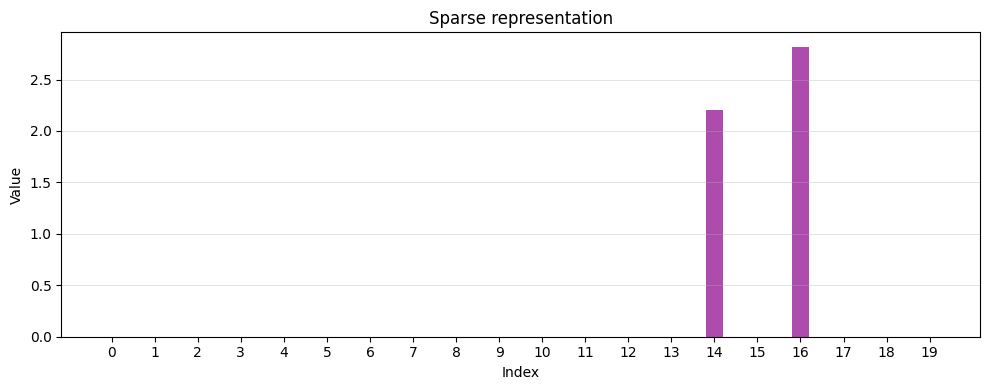

In [18]:
example = np.random.randint(len(reference_train_activations))
with torch.no_grad():
    sparse_representation = sae(reference_train_activations[example].to(DEVICE))[0].detach().cpu() # activations of the middle layer of the SAE
print(sparse_representation)

plt.figure(figsize=(10, 4))

# Set up the positions and bar width
bar_width = 0.4
indices = np.arange(hidden_size)



# Plot the original cnn activations
plt.bar(indices, sparse_representation, width=bar_width, color='darkmagenta', alpha=0.7, label='Values')

# Plot the reconstructed cnn activations with an offset and transparency

plt.xticks(indices, labels=indices)

plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.5, axis='y')

# Adding labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sparse representation')


# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()


In [19]:
max_activations_list = [[] for i in range(hidden_size)]

In [20]:
with torch.no_grad():
  for i in range(len(reference_train_activations)):
    sparse_representation = sae(reference_train_activations[i].to(DEVICE))[0] # activations of the middle layer of the SAE
    max_activations_list[torch.argmax(sparse_representation)].append(i)

In [21]:
for l in max_activations_list:
  print(f"Was the neuron with max activation for {len(l)} examples.")

Was the neuron with max activation for 5965 examples.
Was the neuron with max activation for 0 examples.
Was the neuron with max activation for 0 examples.
Was the neuron with max activation for 6216 examples.
Was the neuron with max activation for 7 examples.
Was the neuron with max activation for 0 examples.
Was the neuron with max activation for 0 examples.
Was the neuron with max activation for 0 examples.
Was the neuron with max activation for 1 examples.
Was the neuron with max activation for 5538 examples.
Was the neuron with max activation for 5923 examples.
Was the neuron with max activation for 5902 examples.
Was the neuron with max activation for 6297 examples.
Was the neuron with max activation for 6733 examples.
Was the neuron with max activation for 6794 examples.
Was the neuron with max activation for 0 examples.
Was the neuron with max activation for 4759 examples.
Was the neuron with max activation for 0 examples.
Was the neuron with max activation for 5865 examples.
W

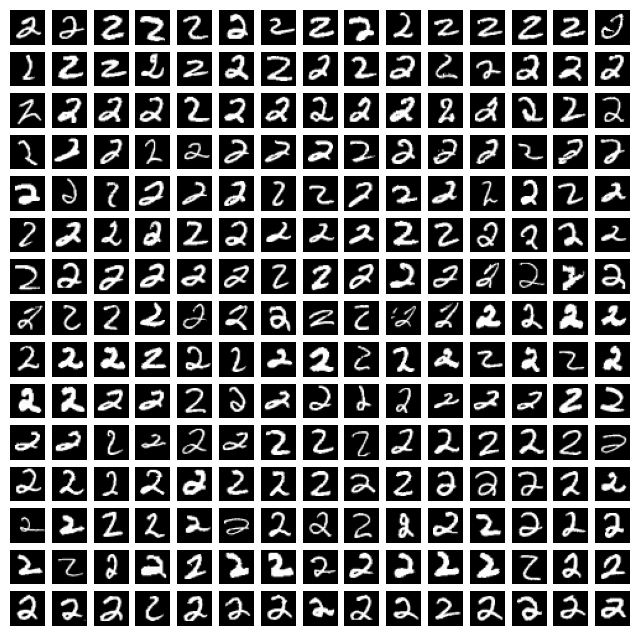

In [23]:
visualize(max_activations_list[0][:225])

In [26]:
encoded_hook_handle = store_inputs(sae.decoder) # the input to the decoder is the encoded input

In [27]:
inputs_hook_handle = store_inputs(sae.encoder) # the input to the sae

In [28]:
fc2_output_hook_handle = store_activations(cnn_model.fc2)

In [29]:
hooks_dict = {}
for name, module in cnn_model.named_children():
    hooks_dict[name] = store_activations(module)

In [30]:
print_registered_forward_hooks(sae)
print_registered_forward_hooks(cnn_model)

Registered forward hooks of SparseAutoencoder:
Module: Linear(in_features=10, out_features=20, bias=True), Hook ID: 11, Hook: store_inputs.<locals>.storing_input_activations_hook
Module: Linear(in_features=20, out_features=10, bias=True), Hook ID: 10, Hook: store_inputs.<locals>.storing_input_activations_hook
Registered forward hooks of CNNModel:
Module: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)), Hook ID: 13, Hook: store_activations.<locals>.storing_activations_hook
Module: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)), Hook ID: 14, Hook: store_activations.<locals>.storing_activations_hook
Module: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)), Hook ID: 15, Hook: store_activations.<locals>.storing_activations_hook
Module: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Hook ID: 16, Hook: store_activations.<locals>.storing_activations_hook
Module: Linear(in_features=576, out_features=64, bias=True), Hook ID: 17, Hook: store_activations.<locals>.

In [31]:
cnn_model.fc2.stored_activations.shape

torch.Size([1, 10])

In [32]:
# remove_all_forward_hooks(sae)

In [33]:
# remove_all_forward_hooks(cnn_model)

In [34]:
sae(reference_train_activations[0])

(tensor([0.0000, 0.0000, 0.0000, 3.5333, 0.9211, 0.0000, 0.0000, 0.0000, 0.0000,
         8.5666, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1277, 0.0000,
         0.0000, 0.0000], device='cuda:0', grad_fn=<ReluBackward0>),
 tensor([7.1250e-06, 8.4299e-06, 6.9054e-07, 1.0000e+00, 3.6151e-07, 1.0000e+00,
         1.6421e-05, 1.3880e-06, 1.9866e-05, 2.6667e-04], device='cuda:0',
        grad_fn=<SigmoidBackward0>))

In [35]:
sae.decoder.stored_inputs

tensor([0.0000, 0.0000, 0.0000, 3.5333, 0.9211, 0.0000, 0.0000, 0.0000, 0.0000,
        8.5666, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1277, 0.0000,
        0.0000, 0.0000], device='cuda:0', grad_fn=<ReluBackward0>)

In [36]:
print(cnn_model.fc2.stored_activations)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [37]:
sample = torch.stack([mnist_by_digit_lists[i][0] for i in range(10)])

In [38]:
optimized_images_dict = {}
for name, layer in cnn_model.named_children():
    if hasattr(layer, 'out_features'):
        out = torch.arange(layer.out_features)
        optimized_images_dict[name] = optim_inputs_for_neurons_in_layer(model=cnn_model, 
                                                                        layer=layer,
                                                                        mode='activations',
                                                                        neuron_indices=out,
                                                                        alpha=2.0,
                                                                        image_sparsity=0,
                                                                        init_inputs='random', 
                                                                        num_steps=1000)

TypeError: optim_inputs_for_neurons_in_layer() got an unexpected keyword argument 'im_init'

In [39]:
visualize_ims(optimized_images_dict['fc2'], channel=0)

KeyError: 'fc2'

In [ ]:
vals, indices = cnn_model.fc2.stored_activations.detach().cpu().topk(5)
well_trained = []
for idx, topk_indices in enumerate(indices):
    if idx in topk_indices:
        plusik = "\U0001F60D"
        well_trained.append(idx)
    else:
        plusik = ''
    
    print(f"{idx}: {topk_indices.tolist()} ~ {vals[idx].numpy()}" + plusik)

print(f"{len(well_trained)} well trained images.")

0: [5, 2, 6, 3, 1] ~ [ 4.937411    3.3552957   2.9302413  -0.68543684 -1.7456121 ]
1: [2, 3, 7, 4, 5] ~ [9.488343   5.6129217  3.8291783  2.3031974  0.29153186]
2: [3, 7, 2, 1, 5] ~ [4.576664   3.7673378  2.7730215  1.6789634  0.44357663]😍
3: [3, 2, 7, 0, 5] ~ [9.649143  7.706528  3.7292826 1.334075  1.3073537]😍
4: [9, 2, 4, 5, 0] ~ [ 4.4520884   4.067602    3.4961295   0.20701393 -2.4626489 ]😍
5: [5, 9, 2, 4, 1] ~ [ 5.129879   4.6438146  4.612869   1.480591  -2.862698 ]😍
6: [2, 7, 1, 3, 4] ~ [ 8.209232   3.2477403  3.1811316  1.5798988 -0.9364564]
7: [5, 1, 9, 2, 7] ~ [3.365341   2.8343368  0.99522716 0.7618716  0.3992385 ]😍
8: [2, 7, 1, 4, 3] ~ [12.664541    3.4051263   2.6073737  -0.03276391 -1.5037818 ]
9: [5, 2, 3, 9, 4] ~ [ 7.1090684  3.3616905  3.0839493  0.4220361 -1.5632958]😍
10: [7, 2, 3, 4, 5] ~ [9.611379  6.7787633 5.7821865 2.8831198 1.0112381]
11: [2, 6, 8, 1, 0] ~ [7.6165876 6.763309  3.254448  1.5814842 1.3167914]
12: [2, 7, 8, 5, 3] ~ [ 8.052489   4.9683695  4.7480493 

In [40]:
combo_model = nn.Sequential(cnn_model, sae)
combo_model.input_shape = (1, 1, 28, 28)

In [41]:
optimized_images_cnn_fc2 = optim_inputs_for_neurons_in_layer(model=combo_model, 
                                                             layer=sae.decoder,
                                                             mode='inputs',
                                                             device=DEVICE,
                                                             neuron_indices=torch.arange(20),
                                                             alpha=2.0,
                                                             image_sparsity=0,
                                                             init_inputs='random', 
                                                             num_steps=10000)

Initial activations: tensor([0.0000, 0.0000, 0.0000, 3.5333, 0.9211, 0.0000, 0.0000, 0.0000, 0.0000,
        8.5666, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1277, 0.0000,
        0.0000, 0.0000], device='cuda:0', grad_fn=<ReluBackward0>)


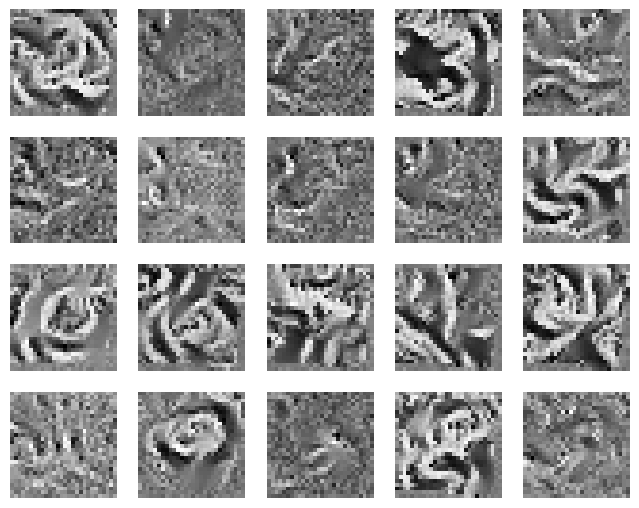

In [43]:
visualize_ims(optimized_images_cnn_fc2, channel=0)

In [ ]:
cnn_model()

tensor([-18.0225,  -9.8141, -34.3493,  10.0203, -28.7933,  24.0919, -14.4446,
        -23.1498, -10.0285,  -1.8420], device='cuda:0')


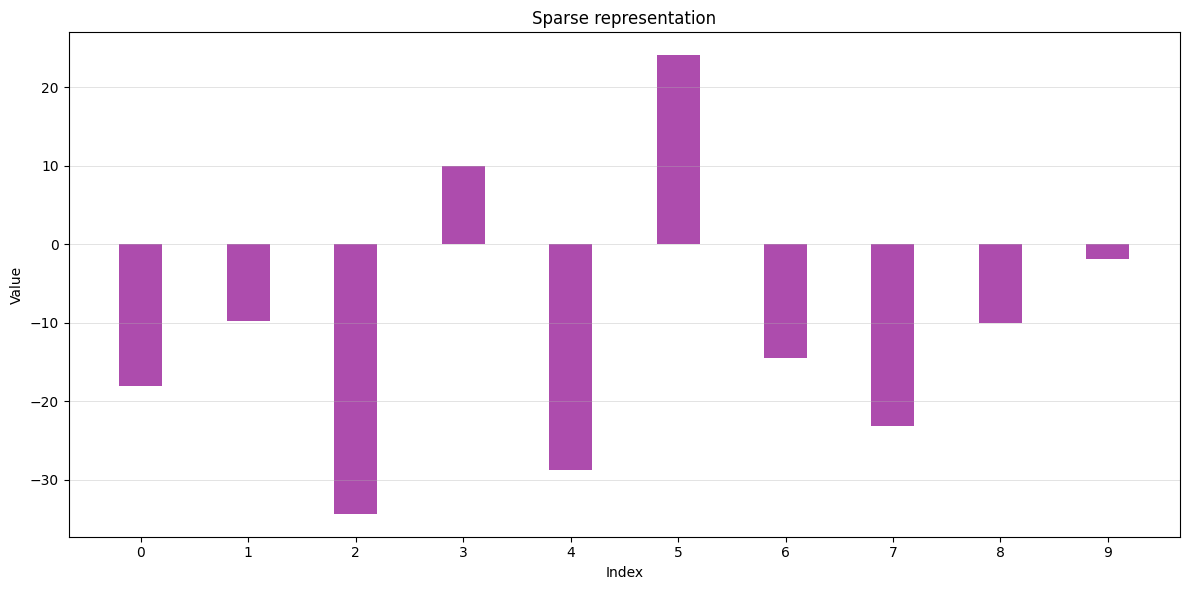

In [ ]:
bar_diagram(cnn_model.fc2.stored_activations[0].flatten().detach(), figsize=(12, 6))


In [ ]:
cnn_model.fc2.stored_activations

tensor([[-18.0225,  -9.8141, -34.3493,  10.0203, -28.7933,  24.0919, -14.4446,
         -23.1498, -10.0285,  -1.8420]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

torch.Size([128, 1, 28, 28])


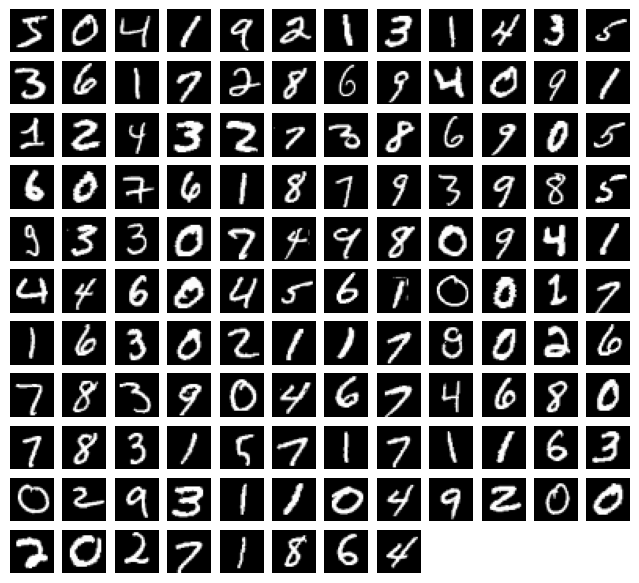

tensor([[-18.0225,  -9.8141, -34.3493,  10.0203, -28.7933,  24.0919, -14.4446,
         -23.1498, -10.0285,  -1.8420]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
batch = next(iter(reference_train_loader))
print(batch[0].shape)
visualize_ims(batch[0], 0)
cnn_model(batch[0][:1].to(DEVICE))

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    print(f"data_grad = {data_grad}")
    print(f"sign_data_grad = {sign_data_grad}")
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(DEVICE)
    if isinstance(std, list):
        std = torch.tensor(std).to(DEVICE)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
def test(model, epsilon, dataset=mnist_train, device=DEVICE):

    # Accuracy counter

    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i in range(len(dataset)):

        # Send the data and label to the device
        data, target = dataset[0][i].to(device).unsqueeze(0), dataset[1][i].to(device).unsqueeze(0)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = TF.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples